# Categorisez automatiquement des questions - Exploration

In [1]:
%%script echo skipping
from google.colab import drive
drive.mount('/content/drive')

skipping


# SOMMAIRE
* [PREPARATION](#PREPARATION)
* [CHARGEMENT](#CHARGEMENT)
* [BAG OF WORDS](#BAG-OF-WORDS)
* [TF-IDF](#TF-IDF)
    * [Documents](#Documents)
    * [Titles](#Titles)
    * [Pondere](#Pondere)
    * [Documents+titles](#Documents+titles)
* [REDUCTION DIMENSIONNELLE](#REDUCTION-DIMENSIONNELLE)
* [CLUSTERING](#CLUSTERING)
* [Bi-grams](#Bi-grams)
* [Tri-grams](#Tri-grams)
* [LDA](#LDA)

# PREPARATION

## Import des librairies

In [2]:
import joblib
import pandas as pd
import matplotlib as mplt
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn import cluster, metrics

## Paramétrage du notebook

In [3]:
from matplotlib import font_manager

font_dirs = ['/Library/Fonts/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

# set font
plt.rcParams['font.family'] = 'Comic Sans'
plt.rcParams['font.sans-serif'] = 'Franklin Gothic Book'

In [4]:
sns.set(rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'lightgrey',
 'axes.facecolor': 'None',
 'axes.grid': False,
 'axes.labelcolor': 'dimgrey',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'dimgrey',
 'xtick.bottom': False,
 'xtick.color': 'dimgrey',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'dimgrey',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False})

#mplt.font_manager._rebuild()
#mplt.font_manager.findfont('Franklin Gothic Book',rebuild_if_missing=True)


pd.options.display.max_colwidth=200
pd.options.display.min_rows=25
pd.options.display.max_columns=50

## Declaration des fonctions

In [5]:
from collections import Counter

def count_words(list):
    # create counter and run through all data
    counter = Counter()
    freq = Counter(list) 
    return freq

def bow(documents):
    cv=CountVectorizer()
    cv.fit(documents)
    vector=cv.transform(documents)
    dfBOW=pd.DataFrame(data=vector.toarray(),columns=cv.get_feature_names_out())
    return dfBOW

# CHARGEMENT

In [6]:
#dfCleaned=joblib.load("drive/MyDrive/Colab Notebooks/Datasets/dfCleaned.jbl.bz2")
dfCleaned=joblib.load('dfCleaned2000.jbl.bz2')

In [7]:
dfCleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 611 to 13808
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Title          2000 non-null   object
 1   Body           2000 non-null   object
 2   Tags           2000 non-null   object
 3   FilteredBody   2000 non-null   object
 4   FilteredTitle  2000 non-null   object
 5   BodyTokens     2000 non-null   object
 6   TitleTokens    2000 non-null   object
 7   BodyLemmas     2000 non-null   object
 8   TitleLemmas    2000 non-null   object
dtypes: object(9)
memory usage: 156.2+ KB


In [8]:
dfCleaned.sample(8)

,Title,Body,Tags,FilteredBody,FilteredTitle,BodyTokens,TitleTokens,BodyLemmas,TitleLemmas
48004,python selenium: find element by css properties,"<p><em>hi community! this is my first question, i hope that i do not violate any rules. any help is highly appreciated - thank you all in advance!</em></p>\n<p><strong>my problem</strong> can be d...",python css selenium,hi community first question hope violate rules help highly appreciated thank problem described follows trying scrape content two consecutive finding first fairly easy know ex name however informat...,python selenium find element css properties,"[hi, community, first, question, hope, violate, rules, help, highly, appreciated, thank, problem, described, follows, trying, scrape, content, two, consecutive, finding, first, fairly, easy, know,...","[python, selenium, find, element, css, properties]","[hi, community, first, question, hope, violate, rule, help, highly, appreciate, thank, problem, described, follow, try, scrape, content, two, consecutive, find, first, fairly, easy, know, ex, name...","[python, selenium, find, element, cs, property]"
46876,perl - subroutine redefined,"<p>i have asked this question before or searched and seen others ask - why am i getting the warning ""<em>subroutine mysub redefined at ../lib/common.pm line x</em>""? and you always get the answer ...",perl subroutine,asked question searched seen others ask getting warning subroutine mysub redefined lib common pm line x always get answer declared sub twice code created test p entire file p mycommonpkg use stric...,perl subroutine redefined,"[asked, question, searched, seen, others, ask, getting, warning, subroutine, mysub, redefined, lib, common, pm, line, always, get, answer, declared, sub, twice, code, created, test, entire, file, ...","[perl, subroutine, redefined]","[ask, question, search, see, others, ask, get, warn, subroutine, mysub, redefine, lib, common, pm, line, always, get, answer, declare, sub, twice, code, create, test, entire, file, mycommonpkg, us...","[perl, subroutine, redefine]"
3116,"how does ""delete"" reclaim memory?",<p>i would like to concentrate on what happens when we say delete ptr. i know that a destructor of our class is called and then the amount of space new allocated is reclaimed.</p>\n\n<p>if our obj...,c++ memory-management,would like concentrate happens say delete ptr know destructor class amount sp new allo reclaimed object pointers etc would reclaimed well definition constructor,delete reclaim memory,"[would, like, concentrate, happens, say, delete, ptr, know, destructor, class, amount, sp, new, allo, reclaimed, object, pointers, etc, would, reclaimed, well, definition, constructor]","[delete, reclaim, memory]","[would, like, concentrate, happens, say, delete, ptr, know, destructor, class, amount, sp, new, allo, reclaim, object, pointer, etc, would, reclaim, well, definition, constructor]","[delete, reclaim, memory]"
42773,how to align radio button list with text input list,"<p>with a my quiz creator interface, the user enters three answers then marks the correct one by setting the radio button:</p>\n\n<p><a href=""http://jsfiddle.net/vleph/2/"" rel=""nofollow"">http://js...",jquery-mobile,quiz creator interf user enters three answers marks correct one setting r button href http jsfi net vleph rel nofollow http jsfi net vleph however get text input checkbox line nicely prefer would ...,align radio button list text input list,"[quiz, creator, interf, user, enters, three, answers, marks, correct, one, setting, button, href, http, jsfi, net, vleph, rel, nofollow, http, jsfi, net, vleph, however, get, text, input, checkbox...","[align, radio, button, list, text, input, list]","[quiz, creator, interf, user, enters, three, answer, mark, correct, one, set, button, href, http, jsfi, net, vleph, rel, nofollow, http, jsfi, net, vleph, however, get, text, input, checkbox, line...","[align, radio, button, list, text, input, list]"
40849,c# vlc 1.1 wrapper,"<p>does anyone 

In [9]:
#dfCleaned=dfCleaned.sample(100)

# BAG OF WORDS

In [10]:
#dfTest=pd.DataFrame({'Lemmas':[['tab','fractionally', 'observe', 'location', 'tab', 'observe', 'space', 'element', 'observe'],['angular','method', 'export', 'look', 'method', 'alert', 'function', 'method', 'observe']]})
#documentsTest=dfTest['Lemmas'].map(' '.join)

documents=dfCleaned['BodyLemmas'].map(' '.join)
documents.sample(5)

24097    two page page page page root server asp page asp root directory need via ajax send request page page get week server put vari test page far page code obviously incomplete page stuck next even go r...
17911                                                                                             want page marked index page marked foo page marked ru etc page page number footer like page numbered etc right
33543    code controller public function allcountries country new app country getallcountries app setlo fr return view country list country country get countrylist definition method fetch public function g...
47677    javascript slide show image text want mange j code retrieve image text code please anyone help difficult aspx page form id form runat server div tm script type text javascript src j scroller j scr...
15446    hdfs use webhdfs question browser request url href http webhdfs user op liststatus rel nofollow noreferrer http webhdfs user op liststatus response text re

In [11]:
dfBowDocuments=bow(documents)
nBow=dfBowDocuments.to_numpy() # optimisation des calculs en passant par numpy

In [12]:
# suppression complémentaire en ajustant par rapport à la frequence des bag of words qui suivent
#documentsFiltered=documents.replace('([0-9]+[a-z]+|[\d+]|[abcd]{2,}[a-z]*)', ' ',regex=True).astype(str)
#documentsFiltered.sample(5)

In [13]:
%%time
dfSumBowDocuments=pd.DataFrame(data=nBow.sum(axis=0))
#dfSumBowDocuments=dfBowDocuments.sum()
dfSumBowDocuments.index=dfBowDocuments.columns
dfSumBowDocuments.columns=['count']

dfSumBowDocuments.sort_values(by='count',ascending=False).head(25)
#dfSumBowDocuments.sort_values(ascending=False).head(25)

CPU times: user 35.9 ms, sys: 15.3 ms, total: 51.1 ms
Wall time: 50 ms


,count
use,1992
quot,1481
class,1372
get,1356
value,1221
new,1210
http,1198
com,1145
file,1121
code,1104


In [14]:
# Ajout de stopwords à exclure

#exclude_stopwords = ['like','want','would','come','get']
#dfCleaned['BodyLemmas']=dfCleaned['BodyLemmas'].map(lambda x: list(set(x).difference(exclude_stopwords)))

In [15]:
#dfTest=pd.DataFrame({'Lemmas':[['tab','fractionally', 'observe', 'location', 'tab', 'observe', 'space', 'element', 'observe'],['angular','method', 'export', 'look', 'method', 'alert', 'function', 'method', 'observe']]})
#documentsTest=dfTest['Lemmas'].map(' '.join)

titles=dfCleaned['TitleLemmas'].map(' '.join)
titles.sample(5)

16130      get servletcontext applicationlistener
1765             show behave inconsistently julia
3711              spawn set thread iteratively 11
17695    visual studio 2010 setup create add file
27453    algorithmic issue determine user session
Name: TitleLemmas, dtype: object

In [16]:
dfBowTitles=bow(titles)
nBow=dfBowTitles.to_numpy() # optimisation des calculs en passant par numpy

In [17]:
%%time
dfSumBowTitles=pd.DataFrame(data=nBow.sum(axis=0))
#dfSumBowDocuments=dfBowDocuments.sum()
dfSumBowTitles.index=dfBowTitles.columns
dfSumBowTitles.columns=['count']

dfSumBowTitles.sort_values(by='count',ascending=False).head(25)
#dfSumBowDocuments.sort_values(ascending=False).head(25)

CPU times: user 10.5 ms, sys: 5.85 ms, total: 16.3 ms
Wall time: 14.6 ms


,count
use,213
file,109
get,97
error,83
data,75
function,73
work,71
string,67
add,64
value,62


# TF-IDF

document = body + title  
TF-IDF(document) = TF-IDF(title) * alpha + TF-IDF(body) * (1-alpha)  
par ex. avec alpha=0.8

Etapes:
- Calculer TF-IDF pour le corps pour tous les documents
- Calculer TF-IDF pour le titre de tous les documents
- multiplier le corps TF-IDF avec alpha
- Itérer le titre IF-IDF pour chaque (doc, token)

In [18]:
dfCleaned['BodyTitleLemmas']=dfCleaned['BodyLemmas']+dfCleaned['TitleLemmas']

In [19]:
%%time
documents=dfCleaned['BodyLemmas'].map(' '.join)
titles=dfCleaned['TitleLemmas'].map(' '.join)
documents_titles=dfCleaned['BodyTitleLemmas'].map(' '.join)

CPU times: user 12.5 ms, sys: 931 µs, total: 13.5 ms
Wall time: 13.3 ms


In [20]:
documents[0:4]

611      found code print string value work fine pdu status int count var response vari var var var type char sp char malloc memcpy sp var val string printf value string count sp printf var val string free...
46618    get error run spark cluster yarn use aws emr service error root exception send command tr recent last file line raise py quot answer java side empty quot py protocol py answer java side empty hand...
19158          use visual automation interf retrieve string external appli string contain simple html format code etc easy function visual word insert string word document convert html format code word format
46378                                                                                                                                                                                way use ocx control vb java
Name: BodyLemmas, dtype: object

In [21]:
titles[0:4]

611                                                  print integer counter32 value net snmp
46618                                   spark error save parquet indexerror pop empty deque
19158    insert html format string microsoft word document use visual basic preserve format
46378                                                                  use ocx control java
Name: TitleLemmas, dtype: object

In [120]:
# Initialisation du vectoriseur TF IDF de scikit learn
pd.options.display.max_colwidth=1000
pd.options.display.max_columns=80

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer= TfidfVectorizer()

## Documents

In [121]:
%%time
response= vectorizer.fit_transform(documents)
dfTFIDF_documents=pd.DataFrame(response.toarray(),columns=vectorizer.get_feature_names_out())
sortedTFIDF_documents=dfTFIDF_documents.sum(axis=0).sort_values(ascending=False)

CPU times: user 303 ms, sys: 158 ms, total: 461 ms
Wall time: 460 ms


[Text(0.5, 0, 'TFIDF'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'Documents - classement des mots - documents')]

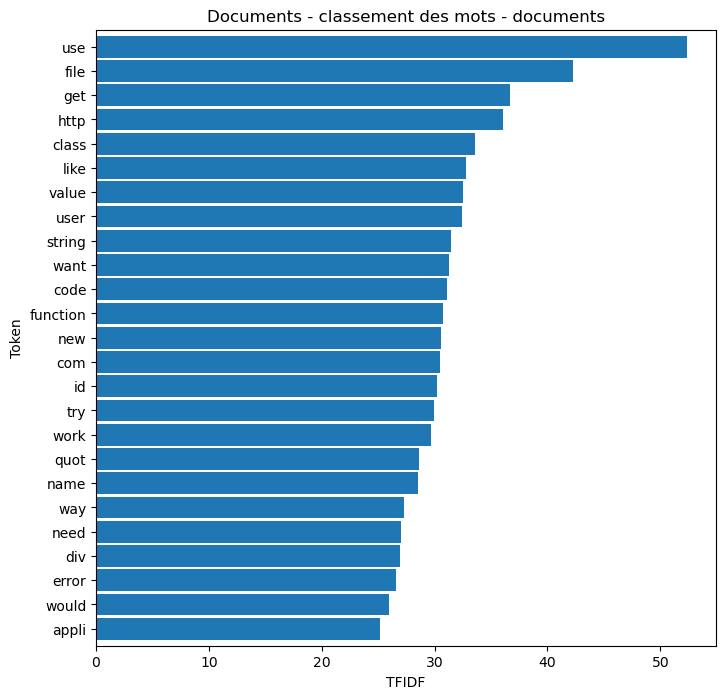

In [122]:
ax = sortedTFIDF_documents.head(25).plot(kind='barh', width=0.90)
ax.invert_yaxis()
ax.set(xlabel='TFIDF', ylabel='Token', title='Documents - classement des mots - documents')

## Titles

In [123]:
%%time
response= vectorizer.fit_transform(titles)
dfTFIDF_titles=pd.DataFrame(response.toarray(),columns=vectorizer.get_feature_names_out())
sortedTFIDF_titles=dfTFIDF_titles.sum(axis=0).sort_values(ascending=False)

CPU times: user 55.4 ms, sys: 22.9 ms, total: 78.2 ms
Wall time: 76.8 ms


[Text(0.5, 0, 'TFIDF'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'Titres - classement des mots - titles')]

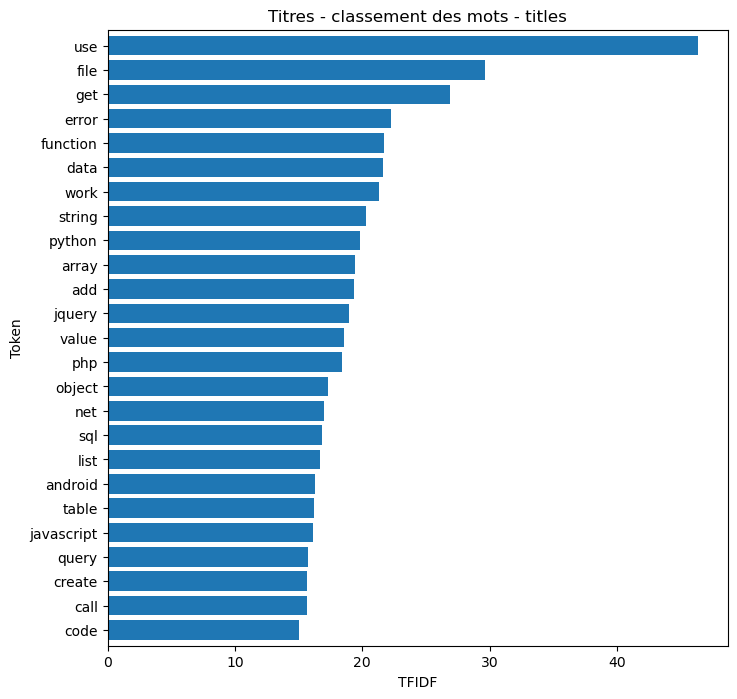

In [124]:
ax = sortedTFIDF_titles.head(25).plot(kind='barh', width=0.80)
ax.invert_yaxis()
ax.set(xlabel='TFIDF', ylabel='Token', title='Titres - classement des mots - titles')

In [125]:
#joblib.dump(dfTFIDF_documents,'dfTFIDF_documents.jbl.bz2')
#joblib.dump(dfTFIDF_titles,'dfTFIDF_titles.jbl.bz2')

In [126]:
#%%time
#import joblib
#
#dfTFIDF_documents=joblib.load('dfTFIDF_documents.jbl.bz2')
#dfTFIDF_titles=joblib.load('dfTFIDF_titles.jbl.bz2')

In [127]:
dfTFIDF_titles.shape,dfTFIDF_documents.shape

((2000, 3140), (2000, 14092))

## Pondere

In [128]:
commonTokens=list(set(dfTFIDF_titles.columns) & set(dfTFIDF_documents.columns))
dfTFIDFCommon=dfTFIDF_titles[0:10000][commonTokens]*0.8+dfTFIDF_documents[0:10000][commonTokens]*0.2
sortedTFIDFCommon=dfTFIDFCommon.sum(axis=0).sort_values(ascending=False)

In [129]:
dfTFIDFCommon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Columns: 2363 entries, measure to nil
dtypes: float64(2363)
memory usage: 36.1 MB


<AxesSubplot:>

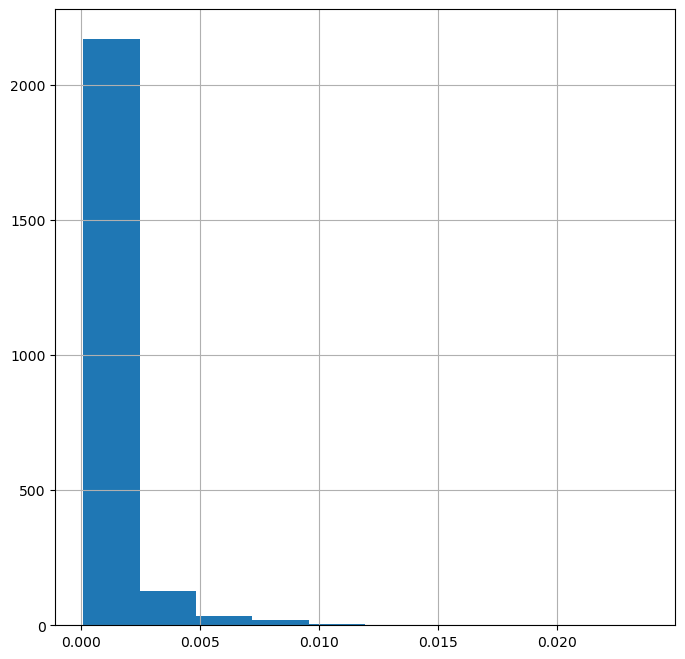

In [130]:
dfTFIDFCommon.mean(axis=0).hist()

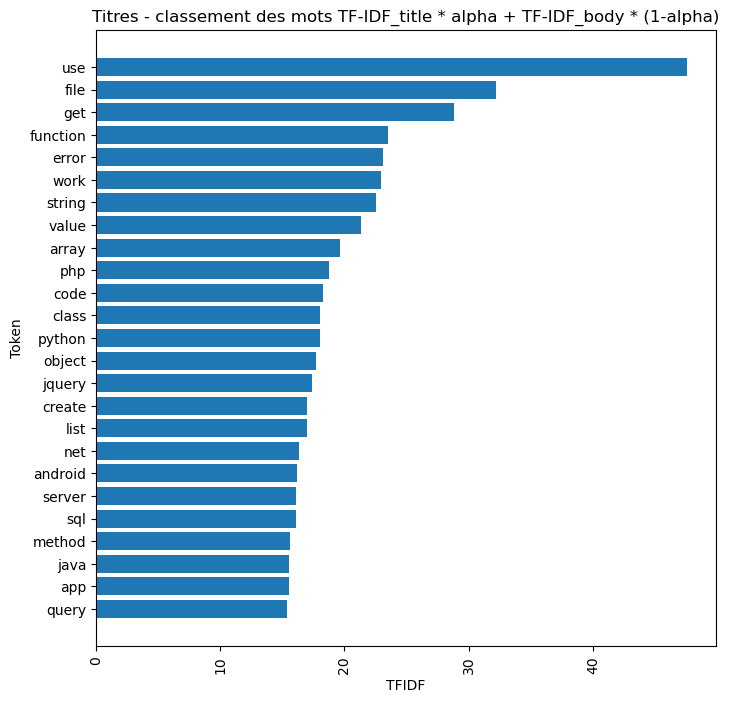

In [131]:
plt.figure(figsize=(8,8))

plt.barh(sortedTFIDFCommon.head(25).index,sortedTFIDFCommon.head(25).values)
plt.gca().invert_yaxis()

plt.xlabel("TFIDF")
plt.xticks(rotation='vertical')

plt.ylabel("Token")
plt.title("Titres - classement des mots TF-IDF_title * alpha + TF-IDF_body * (1-alpha)")
plt.show()

In [132]:
X=dfTFIDFCommon.values

In [133]:
X.shape

(2000, 2363)

In [134]:
#%%time
from sklearn.manifold import TSNE # TSNE module
# Turn dataframe into arrays

# Invoke the TSNE method
tsne = TSNE(random_state=1, method='barnes_hut',n_iter=1000, n_components = 2)
tsne_results = tsne.fit_transform(X)
tsne_results.shape

/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(2000, 2)

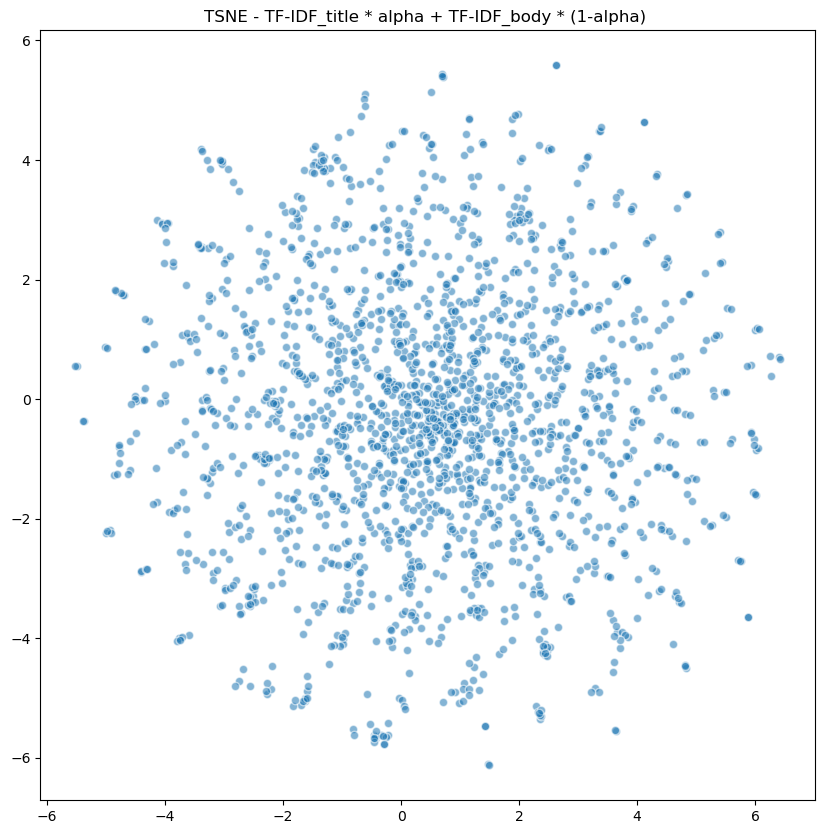

In [135]:
# Plot the TSNE
plt.figure(figsize = (10,10))


plt.scatter(tsne_results[:,0],tsne_results[:,1], edgecolor = "white", alpha=0.55)
plt.title('TSNE - TF-IDF_title * alpha + TF-IDF_body * (1-alpha) ')
plt.show()

## Documents+titles

In [136]:
%%time
response= vectorizer.fit_transform(documents_titles)
dfTFIDF_documents_titles=pd.DataFrame(response.toarray(),columns=vectorizer.get_feature_names_out())
sortedTFIDF_documents_titles=dfTFIDF_documents_titles.sum(axis=0).sort_values(ascending=False)

CPU times: user 320 ms, sys: 165 ms, total: 486 ms
Wall time: 484 ms


[Text(0.5, 0, 'TFIDF'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'Documents - classement des mots TFIDIF documents_titles')]

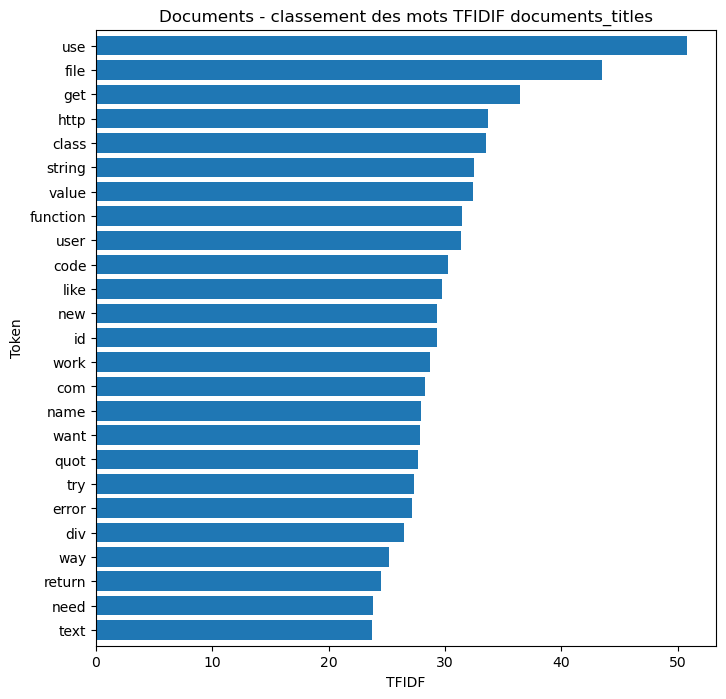

In [137]:
ax = sortedTFIDF_documents_titles.head(25).plot(kind='barh', width=0.80)
ax.invert_yaxis()
ax.set(xlabel='TFIDF', ylabel='Token', title='Documents - classement des mots TFIDIF documents_titles')

In [138]:
X=dfTFIDF_documents_titles.values

In [139]:
#%%time
from sklearn.manifold import TSNE # TSNE module
# Turn dataframe into arrays

# Invoke the TSNE method
tsne = TSNE(random_state=1, method='barnes_hut',n_iter=1000, n_components = 2)
tsne_results = tsne.fit_transform(X)
tsne_results.shape

/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(2000, 2)

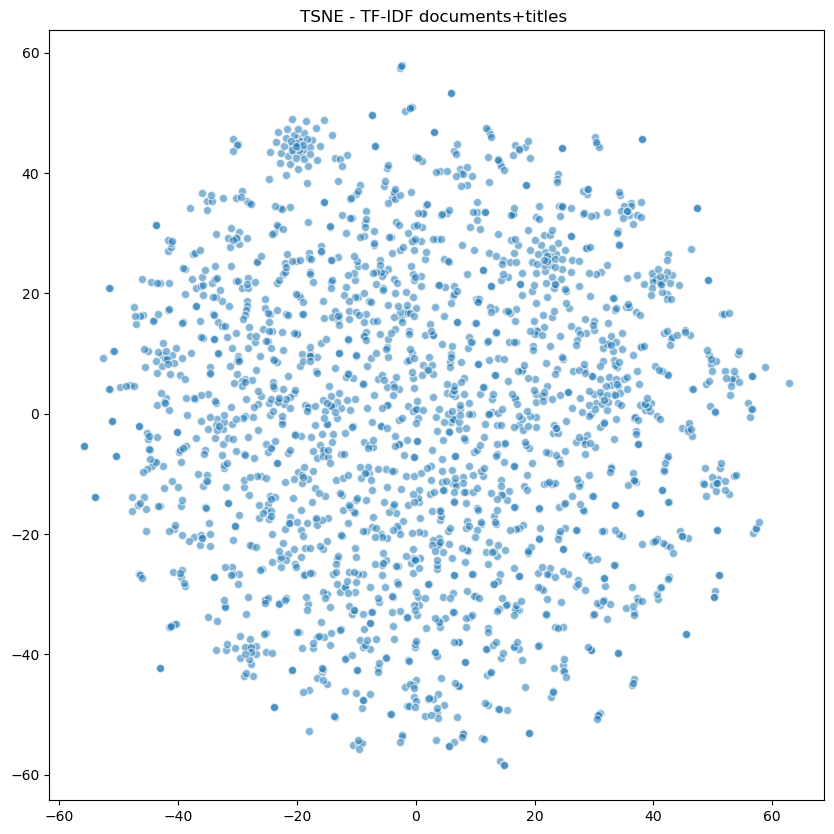

In [140]:
# Plot the TSNE
plt.figure(figsize = (10,10))


plt.scatter(tsne_results[:,0],tsne_results[:,1], edgecolor = "white", alpha=0.55)
plt.title('TSNE - TF-IDF documents+titles ')
plt.show()

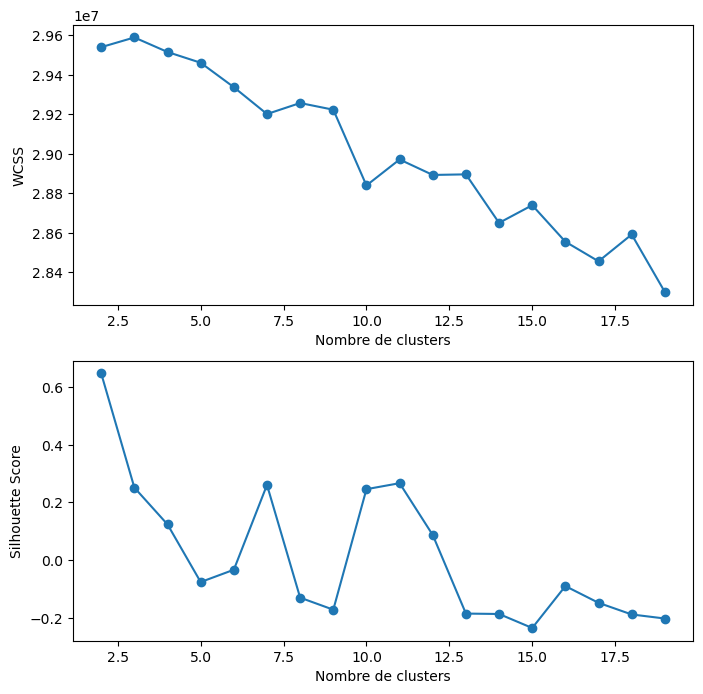

CPU times: user 9min 11s, sys: 20.5 s, total: 9min 32s
Wall time: 55.5 s


In [141]:
%%time
wcss=[] #  somme des carrés intra cluster (somme de la distance au carré entre chaque membre du cluster et son centroïde)
silhouettes=[]
centreReduit = preprocessing.StandardScaler().fit(X)
XCentreReduit = centreReduit.transform(X)

for n in range(2,20):
    cl = cluster.KMeans(n_clusters=n, init='k-means++')# pour avoir une initialisation aleatoire et unique
    y_pred=cl.fit_predict(XCentreReduit)# faire le clustering sur les données normalisée et calculer le coefficient de silhouette
    #labels=cl.labels_
    centroids=cl.cluster_centers_
    wcss.append(cl.inertia_)
    
    silhouette=metrics.silhouette_score(XCentreReduit,y_pred, metric='euclidean')
    silhouettes.append(silhouette)
    
plt.subplot(2, 1, 1);
plt.plot(range(2,20), wcss, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('WCSS')

plt.subplot(2, 1, 2);
plt.plot(range(2,20), silhouettes, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Silhouette Score')
plt.show()

Le calcul de TFIDF sur les documents et titres concaténés donne le même classement que pour le TFIDF sur les documents seuls.  
On preferera donc le TFIDF pondéré sur les titres et documents: TF-IDF_title * alpha + TF-IDF_body * (1-alpha).

# REDUCTION DIMENSIONNELLE

<AxesSubplot:>

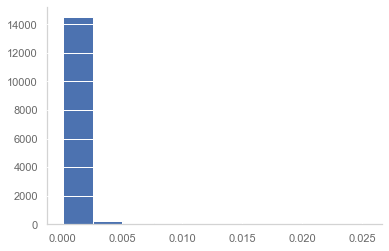

In [43]:
dfTFIDF_documents_titles.mean(axis=0).hist()

In [44]:
# on ne garde que les token avec des TDFIDF significatif (>0.5)
df=dfTFIDFCommon[(dfTFIDFCommon.fillna(0))>0.5].fillna(0)

In [45]:
df

,measure,heroku,ssa,mismatch,arithmetic,tuple,current,thing,maintain,throughout,lead,cli,image,attr,create,collection,separate,log,arrow,compiler,undefined,phpmailer,engine,presence,talk,coercion,innerhtml,keyword,lean,broken,nsurl,ml,full,spark,process,layout,include,malformed,functional,mark,...,product,usersearchmanager,smarty,conditional,membership,euler,stopwatch,publish,flip,rule,phpstorm,stylesheet,seam,sonar,complete,url,bug,go,square,route,aes,conversion,autofill,site,extraneous,firestore,difference,information,ffmpeg,silent,unmarshal,git,super,correct,jsoup,wsdl,imagefield,existence,shape,nil
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Columns: 2363 entries, measure to nil
dtypes: float64(2363)
memory usage: 36.1 MB


## ACP

In [47]:
from sklearn import preprocessing
from sklearn import decomposition

In [48]:
df.sample(5)

,measure,heroku,ssa,mismatch,arithmetic,tuple,current,thing,maintain,throughout,lead,cli,image,attr,create,collection,separate,log,arrow,compiler,undefined,phpmailer,engine,presence,talk,coercion,innerhtml,keyword,lean,broken,nsurl,ml,full,spark,process,layout,include,malformed,functional,mark,...,product,usersearchmanager,smarty,conditional,membership,euler,stopwatch,publish,flip,rule,phpstorm,stylesheet,seam,sonar,complete,url,bug,go,square,route,aes,conversion,autofill,site,extraneous,firestore,difference,information,ffmpeg,silent,unmarshal,git,super,correct,jsoup,wsdl,imagefield,existence,shape,nil
1753,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1604,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1512,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.510819,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
590,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
dataPCA=df
dataPCA.info(),dataPCA.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Columns: 2363 entries, measure to nil
dtypes: float64(2363)
memory usage: 36.1 MB


(None,
 Index(['measure', 'heroku', 'ssa', 'mismatch', 'arithmetic', 'tuple',
        'current', 'thing', 'maintain', 'throughout',
        ...
        'unmarshal', 'git', 'super', 'correct', 'jsoup', 'wsdl', 'imagefield',
        'existence', 'shape', 'nil'],
       dtype='object', length=2363))

In [50]:
X=dataPCA.values
variables=dataPCA.columns # Variables

In [51]:
centreReduit = preprocessing.StandardScaler().fit(X)
XCentreReduit = centreReduit.transform(X)
XCentreReduit.shape

(2000, 2363)

In [96]:
n_comp=800 # n_comp <= nombre de variables
pca = decomposition.PCA(n_components=n_comp)
pca.fit(XCentreReduit)

PCA(n_components=800)

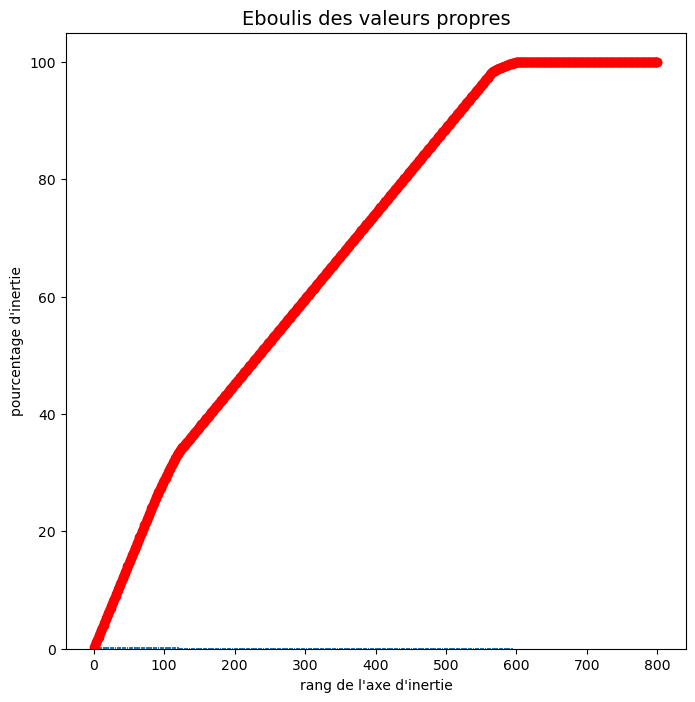

In [97]:
import numpy as np
from matplotlib import pyplot as plt

plt.style.use('default')
# taille du schema
plt.rcParams["figure.figsize"] = (8,8)

vectVarianceExpliquee = pca.explained_variance_ratio_*100 # renvoie les variences expliquées pour chacune des dimensions
plt.bar(np.arange(len(vectVarianceExpliquee))+1, vectVarianceExpliquee)
plt.plot(np.arange(len(vectVarianceExpliquee))+1, vectVarianceExpliquee.cumsum(),c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres",fontsize=14,fontweight='normal')
plt.show()

In [54]:
composantesPrincipales = pca.components_ # triés par variance expliquée

In [55]:
# Selection du plan Factoriel
#dimension 1
d1=0
#dimension 2
d2=1

<timed exec>:36: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


CPU times: user 52.9 ms, sys: 11.4 ms, total: 64.3 ms
Wall time: 54.9 ms


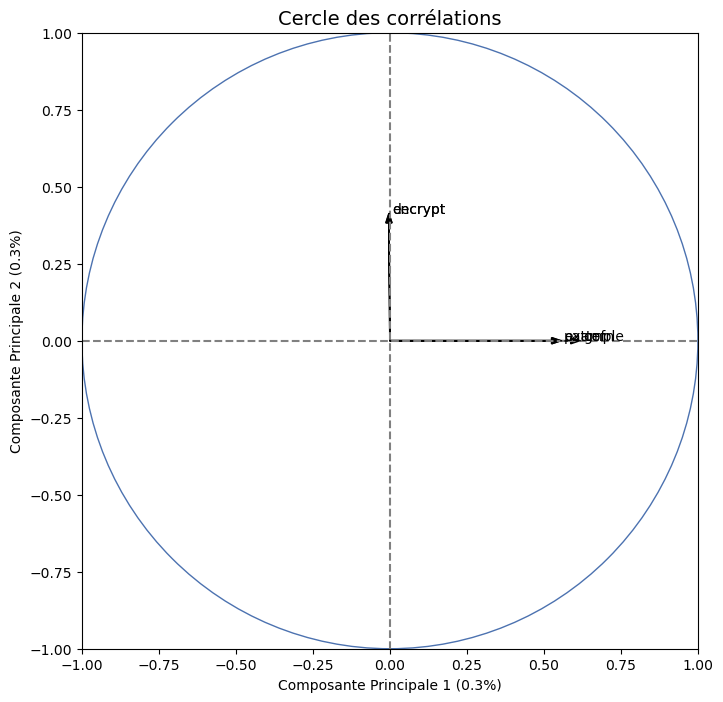

In [98]:
%%time
from matplotlib import pyplot as plt
import matplotlib as mpl

plt.style.use('default')
# taille du schema
plt.rcParams["figure.figsize"] = (8,8)

fig, ax = plt.subplots()

# configuration de la bordure
plt.xlim(-1,1)
plt.ylim(-1,1)

# affichage des lignes horizontales et verticales
plt.plot([-1, 1], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-1, 1], color='grey', ls='--')

# libelles des axes
plt.xlabel('Composante Principale {} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
plt.ylabel('Composante Principale {} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))
plt.title('Cercle des corrélations',color="black",fontsize=14,fontweight='normal')
# afficher le cercle
cercle = plt.Circle((0,0),radius=1, color='b', fill=False)
ax.set_aspect(1)
ax.add_patch(cercle)

    
#placement des étiquettes des p variables + fleches (partant du centre vers les points projetés)
for i in range(len(variables)):
    p=np.array([composantesPrincipales[d1][i],composantesPrincipales[d2][i]])
    # on utilise la distance euclidienne pour n'afficher les labels que pour les individus loin du centre
    distance= np.linalg.norm(p-np.array([0,0]))        
    if distance>0.35:
        plt.annotate(variables[i],xy =(composantesPrincipales[d1][i],composantesPrincipales[d2][i]),xytext =(composantesPrincipales[d1][i]+0.01,composantesPrincipales[d2][i]),arrowprops=dict(arrowstyle="-",
                                connectionstyle="arc3")) 
        plt.arrow(0,0,composantesPrincipales[d1][i],composantesPrincipales[d2][i].astype(np.float),length_includes_head=True,head_width=0.02, head_length=0.03,color="black")

In [57]:
composantesPrincipales[d1]

array([ 6.16197447e-17, -2.95462589e-16, -2.84174276e-16, ...,
        0.00000000e+00,  0.00000000e+00, -3.14420784e-03])

In [58]:
X.shape,composantesPrincipales[d1].shape,composantesPrincipales[d2].shape

((2000, 2363), (2363,), (2363,))

In [59]:
composantesPrincipales

array([[ 6.16197447e-17, -2.95462589e-16, -2.84174276e-16, ...,
         0.00000000e+00,  0.00000000e+00, -3.14420784e-03],
       [-4.47928757e-18,  1.65996539e-16,  1.22218589e-16, ...,
        -0.00000000e+00, -0.00000000e+00, -1.08262070e-02],
       [ 1.14795058e-16, -1.41595238e-16, -2.14928806e-16, ...,
        -0.00000000e+00, -0.00000000e+00,  8.77093796e-02],
       ...,
       [-3.00446757e-16,  2.48479522e-17, -1.70309193e-16, ...,
        -0.00000000e+00, -0.00000000e+00, -7.43171515e-07],
       [ 1.39621639e-17,  1.12759542e-16,  2.10694944e-17, ...,
         0.00000000e+00,  0.00000000e+00,  6.49952829e-07],
       [-1.22948865e-16,  4.12785941e-17, -1.44866279e-16, ...,
        -0.00000000e+00, -0.00000000e+00, -1.17201819e-06]])

In [60]:
#%%time
from sklearn.manifold import TSNE

tsne = TSNE(random_state=1, n_jobs=2,n_iter=1000, n_components = 2)
tsne_results = tsne.fit_transform(composantesPrincipales)
tsne_results.shape

/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(300, 2)

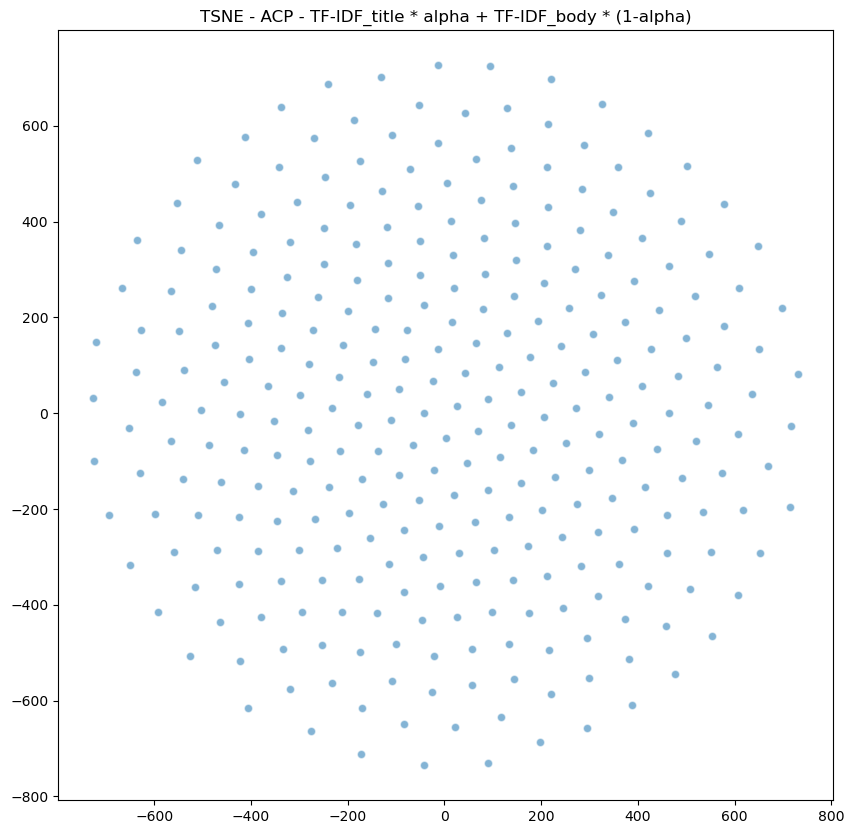

In [61]:
plt.figure(figsize = (10,10))


plt.scatter(tsne_results[:,0],tsne_results[:,1], edgecolor = "white", alpha=0.55)
plt.title('TSNE - ACP - TF-IDF_title * alpha + TF-IDF_body * (1-alpha)')
plt.show()

# CLUSTERING

In [62]:
X=df.values

## KMeans

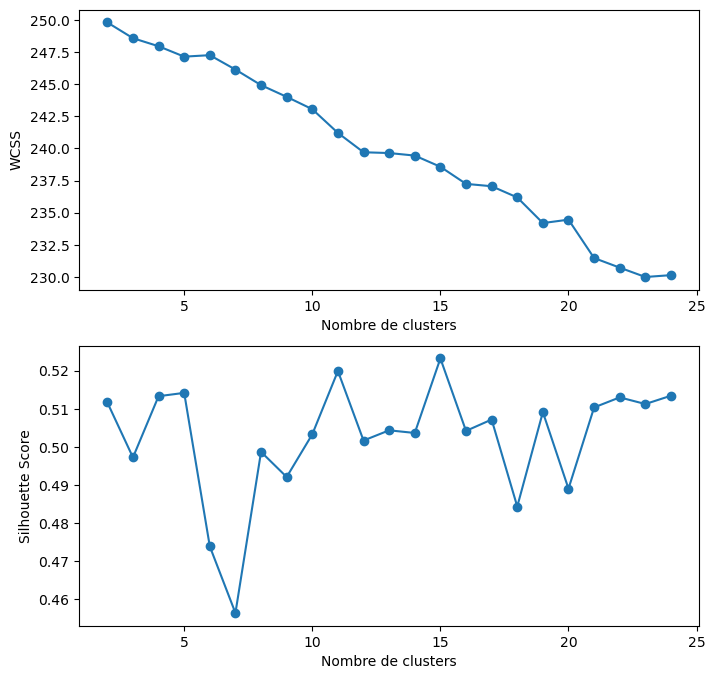

In [63]:
wcss=[] #  somme des carrés intra cluster (somme de la distance au carré entre chaque membre du cluster et son centroïde)
silhouettes=[]

for n in range(2,25):
    cl = cluster.KMeans(n_clusters=n, init='k-means++')# pour avoir une initialisation aleatoire et unique
    y_pred=cl.fit_predict(X)# faire le clustering sur les données normalisée et calculer le coefficient de silhouette
    #labels=cl.labels_
    centroids=cl.cluster_centers_
    wcss.append(cl.inertia_)
    
    silhouette=metrics.silhouette_score(X,y_pred, metric='euclidean')
    silhouettes.append(silhouette)
    
plt.subplot(2, 1, 1);
plt.plot(range(2,25), wcss, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('WCSS')

plt.subplot(2, 1, 2);
plt.plot(range(2,25), silhouettes, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Silhouette Score')
plt.show()

Pour n_clusters = 2 Score de silhouette : 0.6499005257970388
Pour n_clusters = 6 Score de silhouette : 0.5180764799557135
Pour n_clusters = 8 Score de silhouette : 0.5009853556289137
Pour n_clusters = 10 Score de silhouette : 0.5142401660657422


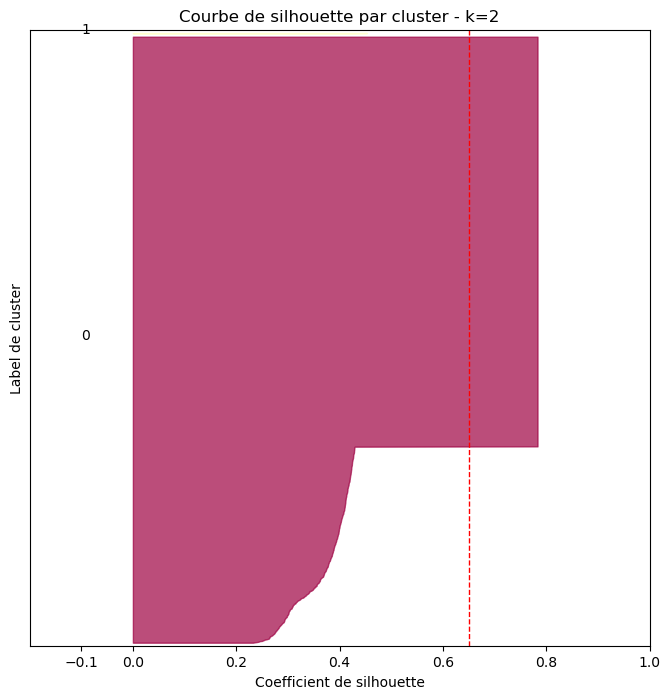

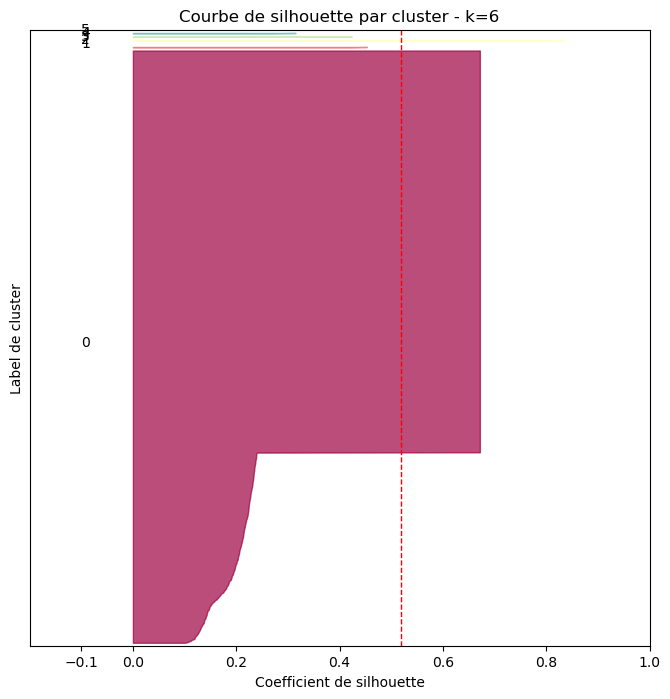

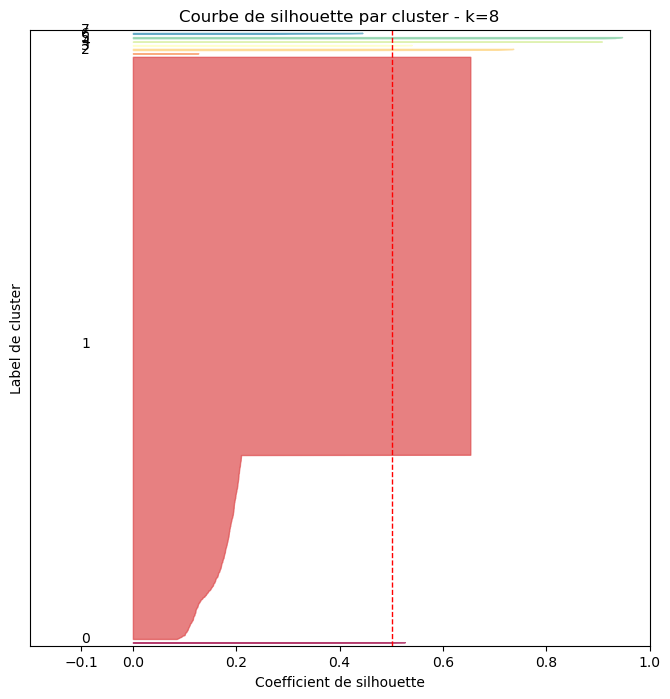

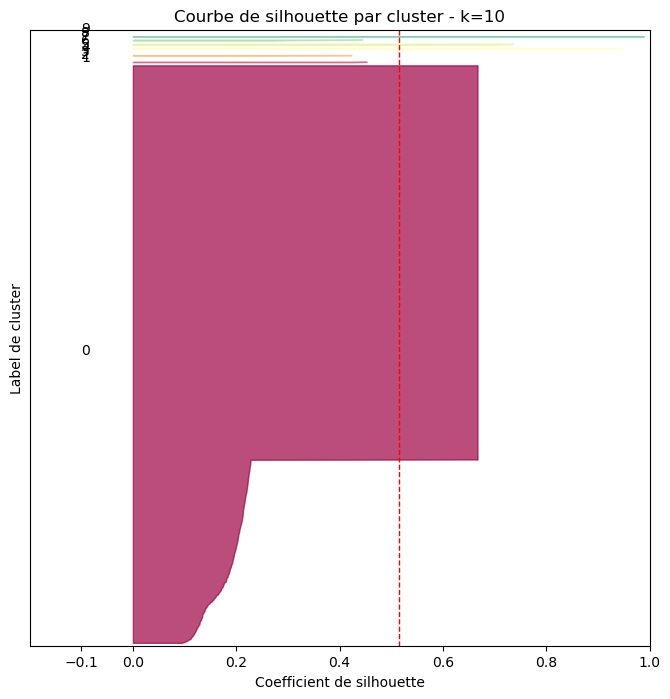

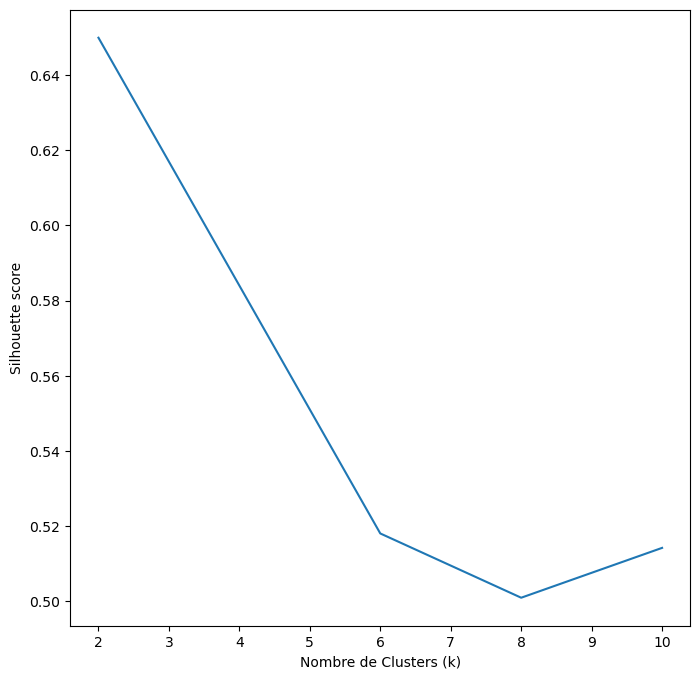

In [64]:
from matplotlib import cm

# Recherche du nombre optimal de clusters par courbes de silhouette

range_n_clusters = [2,6,8,10]
silhouette_avg_n_clusters = []

for n_clusters in range_n_clusters:
    fig, ax = plt.subplots()
    # The silhouette coefficient lie within [-0.2, 1]
    ax.set_xlim([-0.2, 1])
    
    # The (n_clusters+1)*5 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(X) + (n_clusters + 1)*10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 42 for reproducibility.
    cl = cluster.KMeans(n_clusters=n_clusters, random_state=42,init='k-means++')
    cluster_labels = cl.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = metrics.silhouette_score(X, cluster_labels)
    print("Pour n_clusters =", n_clusters,
          "Score de silhouette :", silhouette_avg)

    silhouette_avg_n_clusters.append(silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = metrics.silhouette_samples(X, cluster_labels)
    
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        
        y_upper = y_lower + size_cluster_i

        color = cm.Spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.1, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    ax.set_title("Courbe de silhouette par cluster - k="+str(n_clusters))
    ax.set_xlabel("Coefficient de silhouette")
    ax.set_ylabel("Label de cluster")
    
    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--",linewidth=1)

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
plt.show()


plt.plot(range_n_clusters, silhouette_avg_n_clusters)
plt.xlabel("Nombre de Clusters (k)")
plt.ylabel("Silhouette score")
plt.show()

# Bi-grams

In [143]:
# application de TF IDF de scikit learn sur le document
pd.options.display.max_colwidth=1000
pd.options.display.max_columns=80

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer= TfidfVectorizer(ngram_range = (2,2))

In [144]:
response= vectorizer.fit_transform(documents)
dfTFIDF_documents=pd.DataFrame(response.toarray(),columns=vectorizer.get_feature_names_out())
sortedTFIDF_documents=dfTFIDF_documents.sum(axis=0).sort_values(ascending=False)

[Text(0.5, 0, 'TFIDF'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'Documents - classement des mots - documents')]

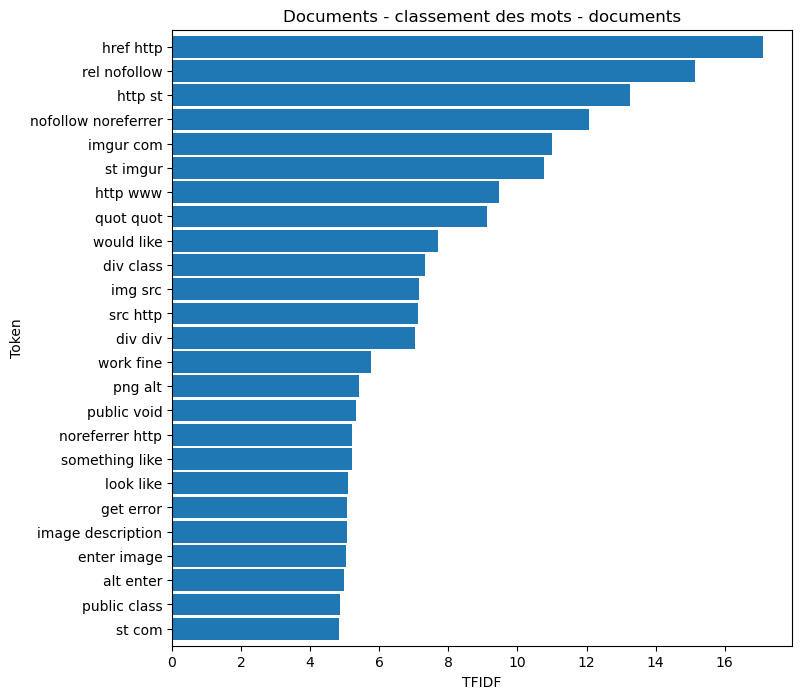

In [145]:
ax = sortedTFIDF_documents.head(25).plot(kind='barh', width=0.90)
ax.invert_yaxis()
ax.set(xlabel='TFIDF', ylabel='Token', title='Documents - classement des mots - documents')

In [146]:
response= vectorizer.fit_transform(titles)
dfTFIDF_titles=pd.DataFrame(response.toarray(),columns=vectorizer.get_feature_names_out())
sortedTFIDF_titles=dfTFIDF_titles.sum(axis=0).sort_values(ascending=False)

[Text(0.5, 0, 'TFIDF'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'Titres - classement des mots - titles')]

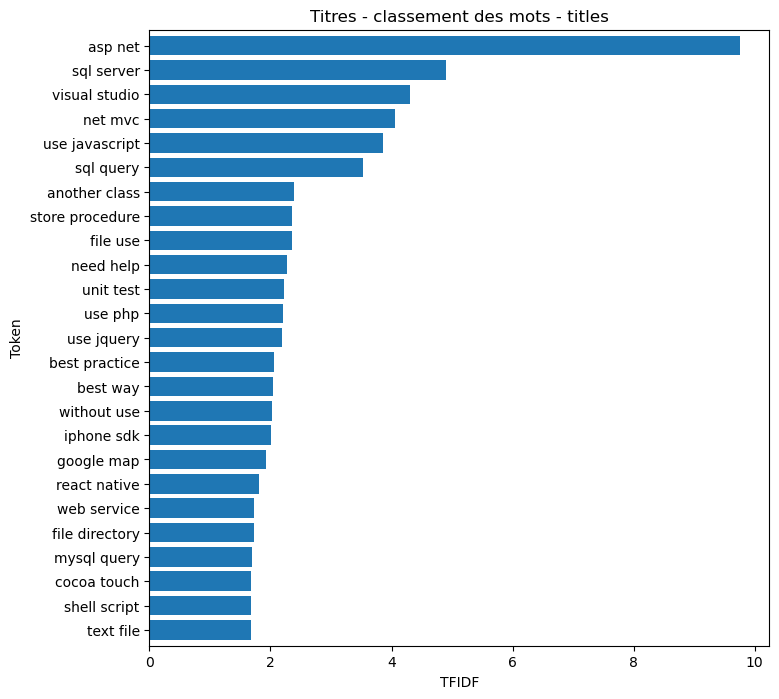

In [147]:
ax = sortedTFIDF_titles.head(25).plot(kind='barh', width=0.80)
ax.invert_yaxis()
ax.set(xlabel='TFIDF', ylabel='Token', title='Titres - classement des mots - titles')

In [148]:
response= vectorizer.fit_transform(documents_titles)
dfTFIDF_documents_titles=pd.DataFrame(response.toarray(),columns=vectorizer.get_feature_names_out())
sortedTFIDF_documents_titles=dfTFIDF_documents_titles.sum(axis=0).sort_values(ascending=False)

[Text(0.5, 0, 'TFIDF'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'Documents - classement des mots TFIDIF documents_titles')]

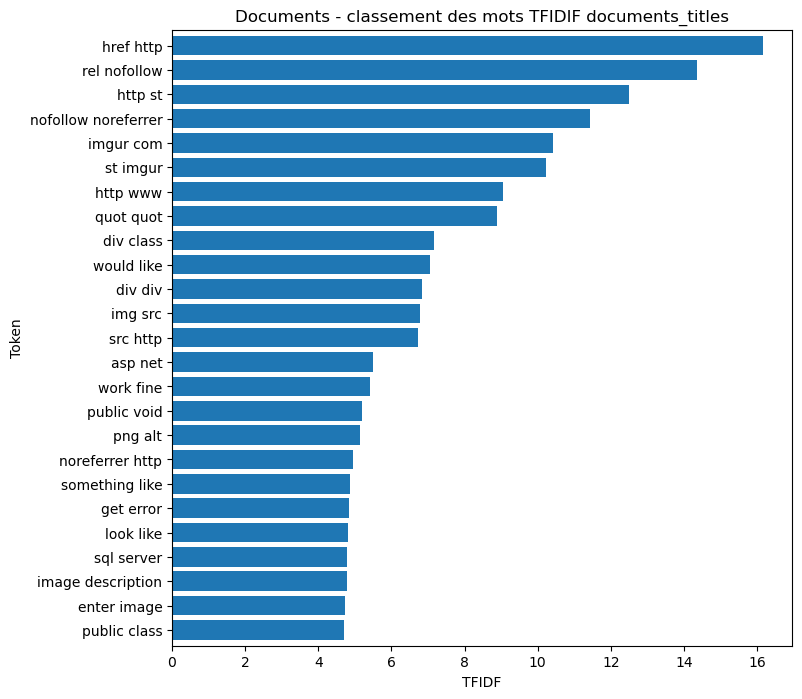

In [149]:
ax = sortedTFIDF_documents_titles.head(25).plot(kind='barh', width=0.80)
ax.invert_yaxis()
ax.set(xlabel='TFIDF', ylabel='Token', title='Documents - classement des mots TFIDIF documents_titles')

In [150]:
X=dfTFIDF_documents_titles.values

In [151]:
#%%time
from sklearn.manifold import TSNE # TSNE module

tsne = TSNE(random_state=1, n_jobs=2,n_iter=1000, n_components = 2)
tsne_results = tsne.fit_transform(X)
tsne_results.shape

/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(2000, 2)

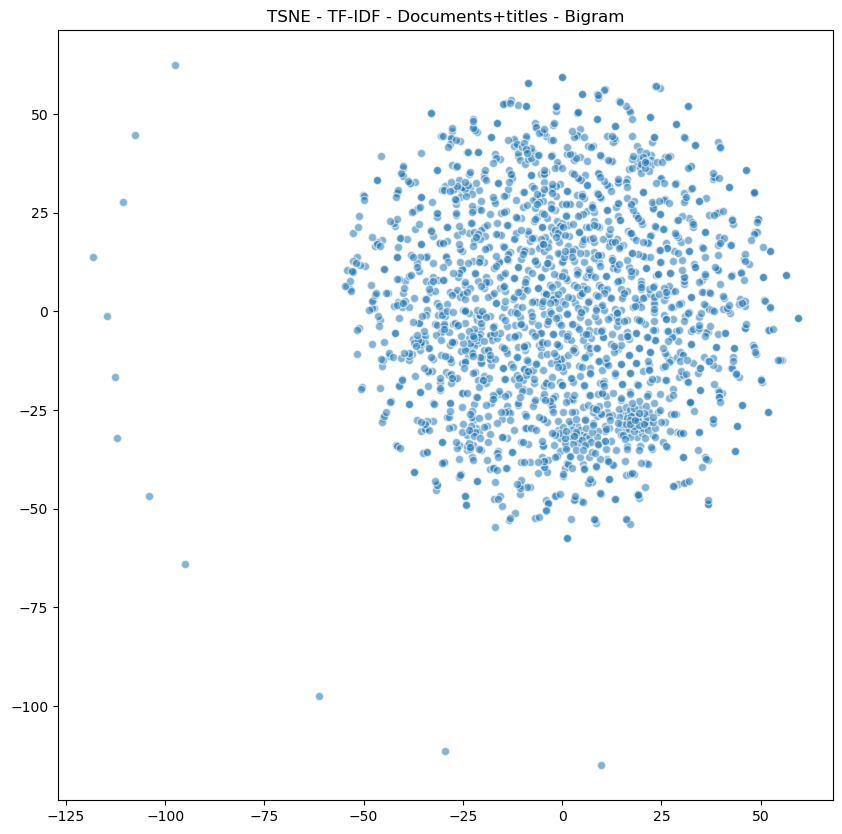

In [152]:
plt.figure(figsize = (10,10))


plt.scatter(tsne_results[:,0],tsne_results[:,1], edgecolor = "white", alpha=0.55)
plt.title('TSNE - TF-IDF - Documents+titles - Bigram')
plt.show()

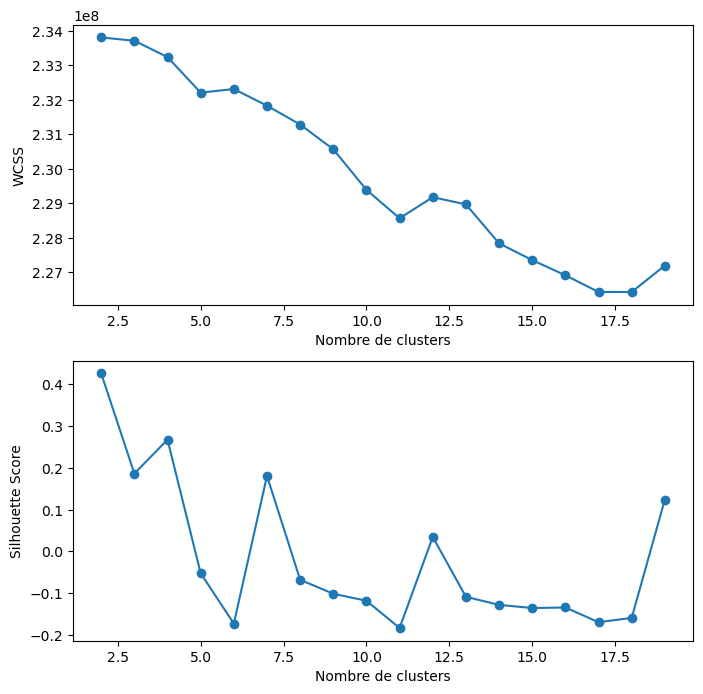

CPU times: user 1h 22min 10s, sys: 2min 30s, total: 1h 24min 40s
Wall time: 9min


In [111]:
%%time
wcss=[] #  somme des carrés intra cluster (somme de la distance au carré entre chaque membre du cluster et son centroïde)
silhouettes=[]
centreReduit = preprocessing.StandardScaler().fit(X)
XCentreReduit = centreReduit.transform(X)

for n in range(2,20):
    cl = cluster.KMeans(n_clusters=n, init='k-means++')# pour avoir une initialisation aleatoire et unique
    y_pred=cl.fit_predict(XCentreReduit)# faire le clustering sur les données normalisée et calculer le coefficient de silhouette
    #labels=cl.labels_
    centroids=cl.cluster_centers_
    wcss.append(cl.inertia_)
    
    silhouette=metrics.silhouette_score(XCentreReduit,y_pred, metric='euclidean')
    silhouettes.append(silhouette)
    
plt.subplot(2, 1, 1);
plt.plot(range(2,20), wcss, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('WCSS')

plt.subplot(2, 1, 2);
plt.plot(range(2,20), silhouettes, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [153]:
commonTokens=list(set(dfTFIDF_titles.columns) & set(dfTFIDF_documents.columns))
dfTFIDFCommon=dfTFIDF_titles[0:10000][commonTokens]*0.8+dfTFIDF_documents[0:10000][commonTokens]*0.2
sortedTFIDFCommon=dfTFIDFCommon.sum(axis=0).sort_values(ascending=False)

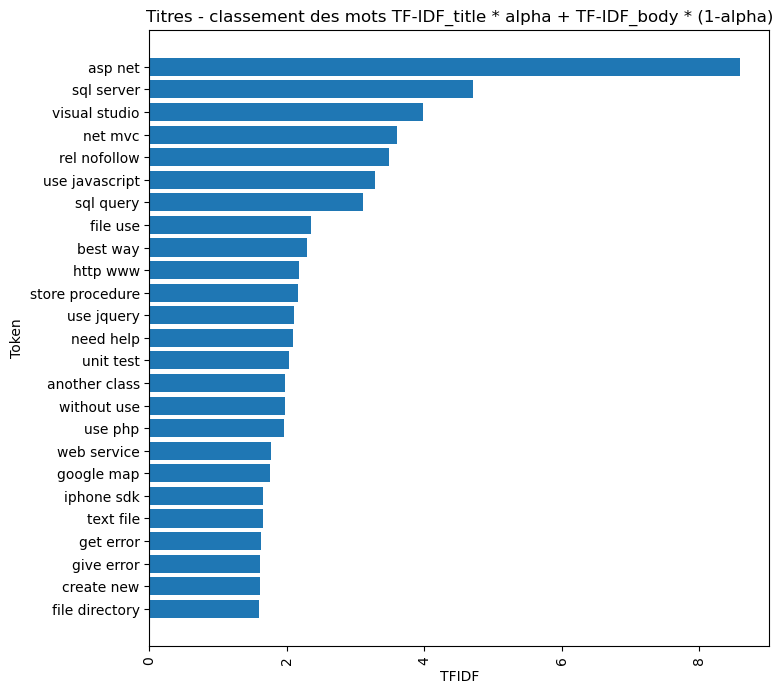

In [154]:
plt.figure(figsize=(8,8))

plt.barh(sortedTFIDFCommon.head(25).index,sortedTFIDFCommon.head(25).values)
plt.gca().invert_yaxis()

plt.xlabel("TFIDF")
plt.xticks(rotation='vertical')

plt.ylabel("Token")
plt.title("Titres - classement des mots TF-IDF_title * alpha + TF-IDF_body * (1-alpha)")
plt.show()

In [155]:
X=dfTFIDFCommon.values

In [156]:
#%%time
from sklearn.manifold import TSNE

tsne = TSNE(random_state=1, n_jobs=2,n_iter=1000, n_components = 2)
tsne_results = tsne.fit_transform(X)
tsne_results.shape

/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(2000, 2)

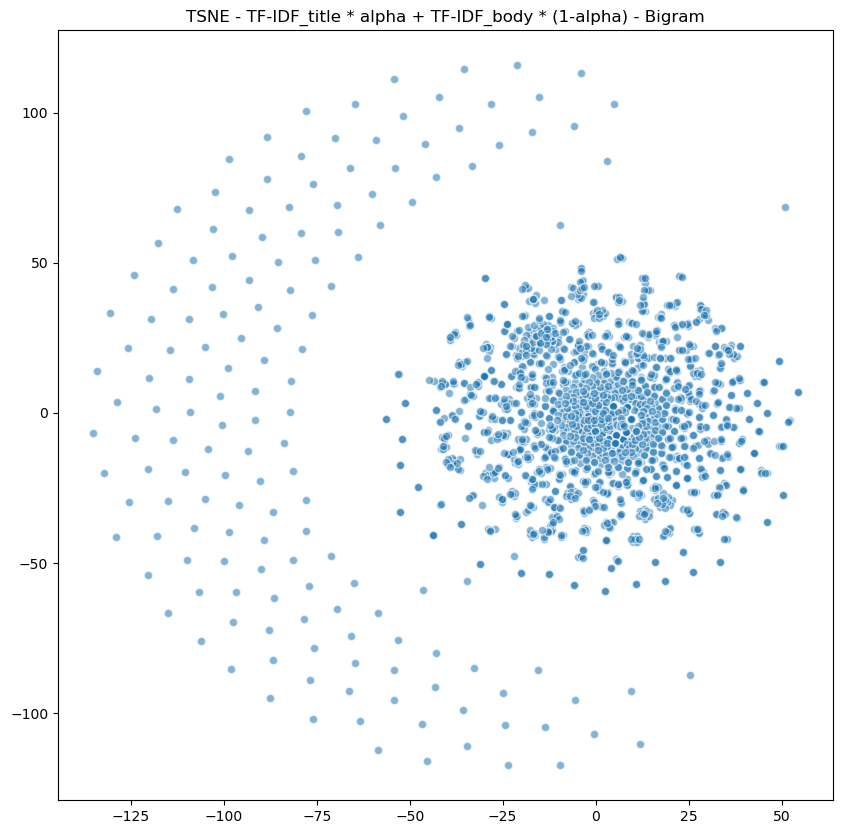

In [157]:
plt.figure(figsize = (10,10))


plt.scatter(tsne_results[:,0],tsne_results[:,1], edgecolor = "white", alpha=0.55)
plt.title('TSNE - TF-IDF_title * alpha + TF-IDF_body * (1-alpha) - Bigram')
plt.show()

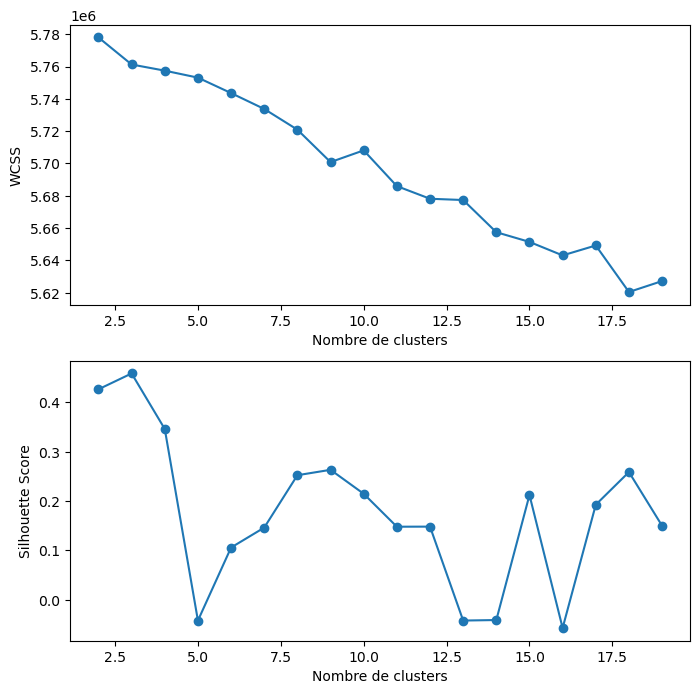

CPU times: user 2min 14s, sys: 7.78 s, total: 2min 22s
Wall time: 14.2 s


In [117]:
%%time
wcss=[] #  somme des carrés intra cluster (somme de la distance au carré entre chaque membre du cluster et son centroïde)
silhouettes=[]
centreReduit = preprocessing.StandardScaler().fit(X)
XCentreReduit = centreReduit.transform(X)

for n in range(2,20):
    cl = cluster.KMeans(n_clusters=n, init='k-means++')# pour avoir une initialisation aleatoire et unique
    y_pred=cl.fit_predict(XCentreReduit)# faire le clustering sur les données normalisée et calculer le coefficient de silhouette
    #labels=cl.labels_
    centroids=cl.cluster_centers_
    wcss.append(cl.inertia_)
    
    silhouette=metrics.silhouette_score(XCentreReduit,y_pred, metric='euclidean')
    silhouettes.append(silhouette)
    
plt.subplot(2, 1, 1);
plt.plot(range(2,20), wcss, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('WCSS')

plt.subplot(2, 1, 2);
plt.plot(range(2,20), silhouettes, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [158]:
dataPCA=dfTFIDFCommon
dataPCA.info(),dataPCA.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Columns: 2895 entries, select list to white mark
dtypes: float64(2895)
memory usage: 44.2 MB


(None,
 Index(['select list', 'faster way', 'request error', 'send file',
        'insert current', 'view error', 'eclipse pydev', 'service provider',
        'never use', 'hit browser',
        ...
        'query result', 'flush true', 'like line', 'pl sql', 'plot histogram',
        'use icommand', 'make install', 'vue cli', 'find second', 'white mark'],
       dtype='object', length=2895))

In [159]:
X=dataPCA.values
variables=dataPCA.columns # Variables

In [160]:
centreReduit = preprocessing.StandardScaler().fit(X)
XCentreReduit = centreReduit.transform(X)
XCentreReduit.shape

(2000, 2895)

In [161]:
n_comp=800 # n_comp <= nombre de variables
pca = decomposition.PCA(n_components=n_comp)
pca.fit(XCentreReduit)

PCA(n_components=800)

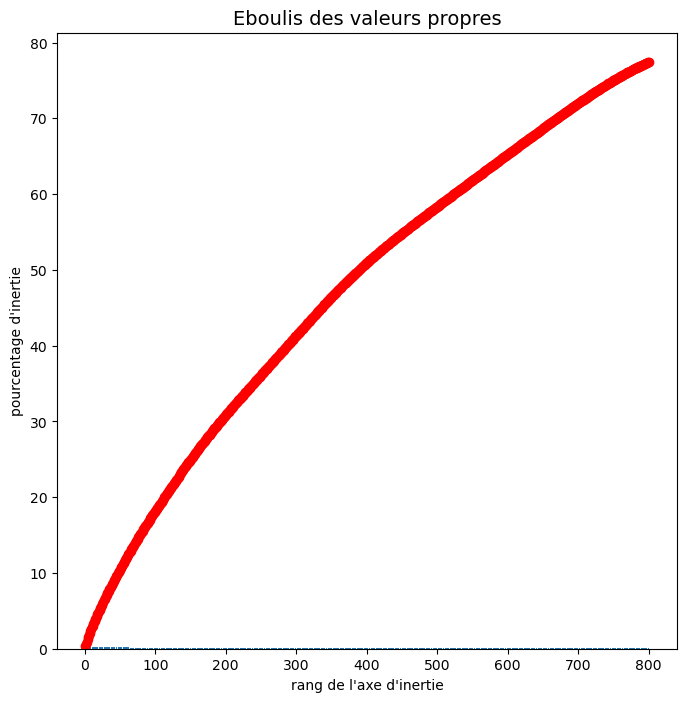

In [162]:
import numpy as np
from matplotlib import pyplot as plt

plt.style.use('default')
# taille du schema
plt.rcParams["figure.figsize"] = (8,8)

vectVarianceExpliquee = pca.explained_variance_ratio_*100 # renvoie les variences expliquées pour chacune des dimensions
plt.bar(np.arange(len(vectVarianceExpliquee))+1, vectVarianceExpliquee)
plt.plot(np.arange(len(vectVarianceExpliquee))+1, vectVarianceExpliquee.cumsum(),c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres",fontsize=14,fontweight='normal')
plt.show()

In [163]:
composantesPrincipales = pca.components_ # triés par variance expliquée

In [164]:
# Selection du plan Factoriel
#dimension 1
d1=0
#dimension 2
d2=1

<timed exec>:36: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


CPU times: user 61.6 ms, sys: 3.15 ms, total: 64.7 ms
Wall time: 62.6 ms


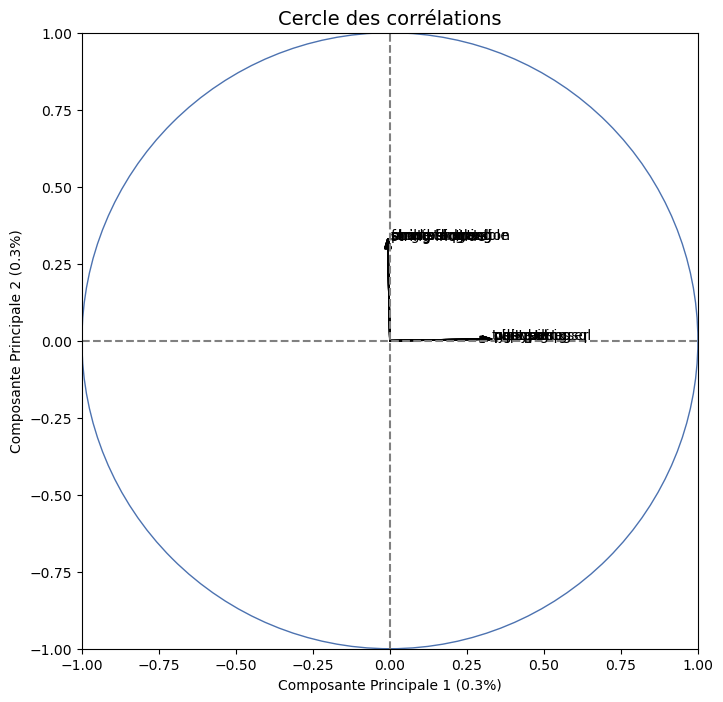

In [170]:
%%time
from matplotlib import pyplot as plt
import matplotlib as mpl

plt.style.use('default')
# taille du schema
plt.rcParams["figure.figsize"] = (8,8)

fig, ax = plt.subplots()

# configuration de la bordure
plt.xlim(-1,1)
plt.ylim(-1,1)

# affichage des lignes horizontales et verticales
plt.plot([-1, 1], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-1, 1], color='grey', ls='--')

# libelles des axes
plt.xlabel('Composante Principale {} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
plt.ylabel('Composante Principale {} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))
plt.title('Cercle des corrélations',color="black",fontsize=14,fontweight='normal')
# afficher le cercle
cercle = plt.Circle((0,0),radius=1, color='b', fill=False)
ax.set_aspect(1)
ax.add_patch(cercle)

    
#placement des étiquettes des p variables + fleches (partant du centre vers les points projetés)
for i in range(len(variables)):
    p=np.array([composantesPrincipales[d1][i],composantesPrincipales[d2][i]])
    # on utilise la distance euclidienne pour n'afficher les labels que pour les individus loin du centre
    distance= np.linalg.norm(p-np.array([0,0]))        
    if distance>0.32:
        plt.annotate(variables[i],xy =(composantesPrincipales[d1][i],composantesPrincipales[d2][i]),xytext =(composantesPrincipales[d1][i]+0.01,composantesPrincipales[d2][i]),arrowprops=dict(arrowstyle="-",
                                connectionstyle="arc3")) 
        plt.arrow(0,0,composantesPrincipales[d1][i],composantesPrincipales[d2][i].astype(np.float),length_includes_head=True,head_width=0.02, head_length=0.03,color="black")

In [171]:
#%%time
from sklearn.manifold import TSNE

tsne = TSNE(random_state=1, n_jobs=2,n_iter=1000, n_components = 2)
tsne_results = tsne.fit_transform(composantesPrincipales)
tsne_results.shape

/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(800, 2)

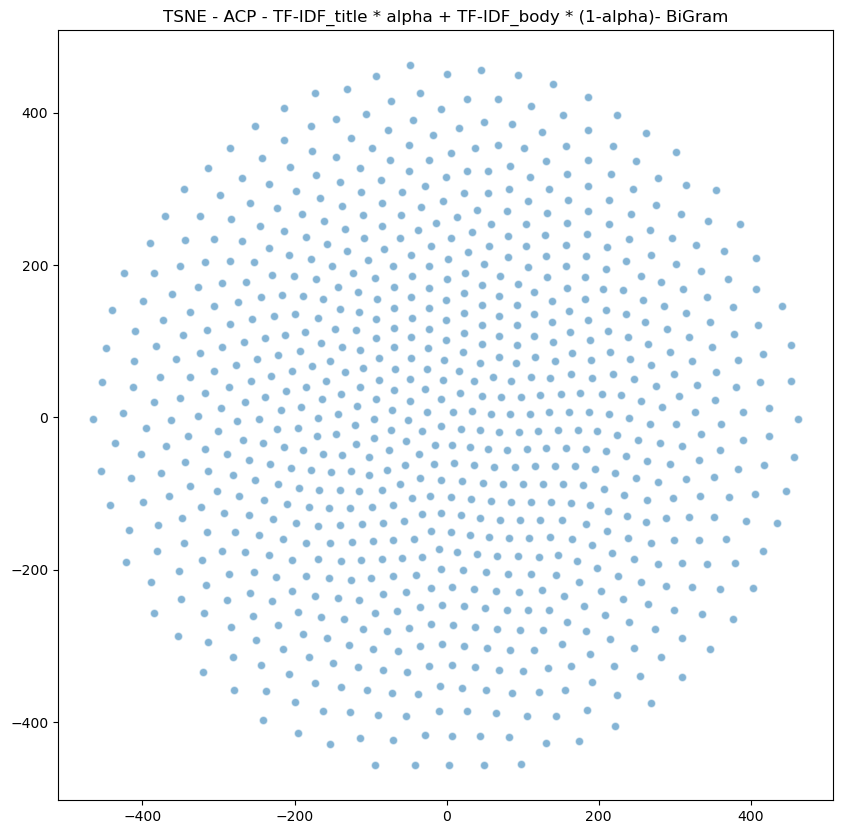

In [172]:
plt.figure(figsize = (10,10))


plt.scatter(tsne_results[:,0],tsne_results[:,1], edgecolor = "white", alpha=0.55)
plt.title('TSNE - ACP - TF-IDF_title * alpha + TF-IDF_body * (1-alpha)- BiGram')
plt.show()

# Tri-grams

In [80]:
%%time
# application de TF IDF de scikit learn sur le document
pd.options.display.max_colwidth=1000
pd.options.display.max_columns=80

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer= TfidfVectorizer(ngram_range = (3,3))



CPU times: user 11.3 ms, sys: 1.15 ms, total: 12.5 ms
Wall time: 4.37 ms


In [81]:
response= vectorizer.fit_transform(documents)
dfTFIDF_documents=pd.DataFrame(response.toarray(),columns=vectorizer.get_feature_names_out())
sortedTFIDF_documents=dfTFIDF_documents.sum(axis=0).sort_values(ascending=False)

[Text(0.5, 0, 'TFIDF'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'Documents - classement des mots - documents')]

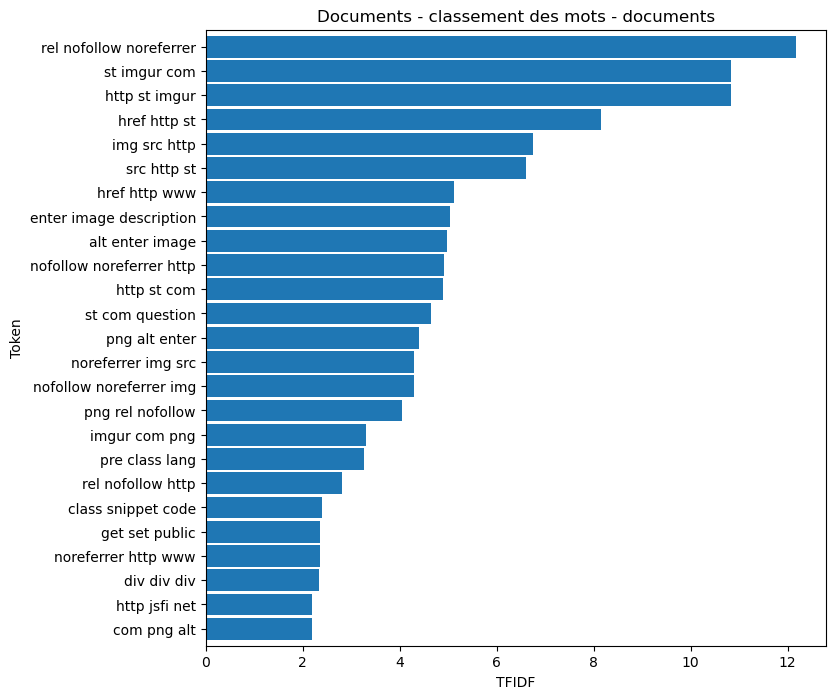

In [82]:
ax = sortedTFIDF_documents.head(25).plot(kind='barh', width=0.90)
ax.invert_yaxis()
ax.set(xlabel='TFIDF', ylabel='Token', title='Documents - classement des mots - documents')

In [83]:
response= vectorizer.fit_transform(titles)
dfTFIDF_titles=pd.DataFrame(response.toarray(),columns=vectorizer.get_feature_names_out())
sortedTFIDF_titles=dfTFIDF_titles.sum(axis=0).sort_values(ascending=False)

[Text(0.5, 0, 'TFIDF'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'Titres - classement des mots - titles')]

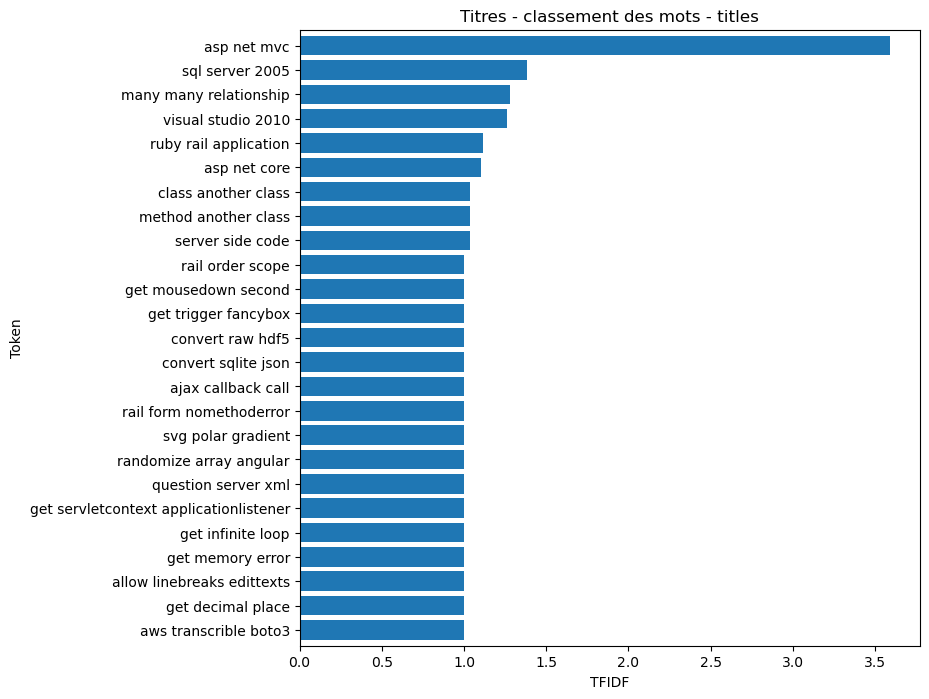

In [84]:
ax = sortedTFIDF_titles.head(25).plot(kind='barh', width=0.80)
ax.invert_yaxis()
ax.set(xlabel='TFIDF', ylabel='Token', title='Titres - classement des mots - titles')

In [85]:
response= vectorizer.fit_transform(documents_titles)
dfTFIDF_documents_titles=pd.DataFrame(response.toarray(),columns=vectorizer.get_feature_names_out())
sortedTFIDF_documents_titles=dfTFIDF_documents_titles.sum(axis=0).sort_values(ascending=False)

[Text(0.5, 0, 'TFIDF'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'Documents - classement des mots TFIDIF documents_titles')]

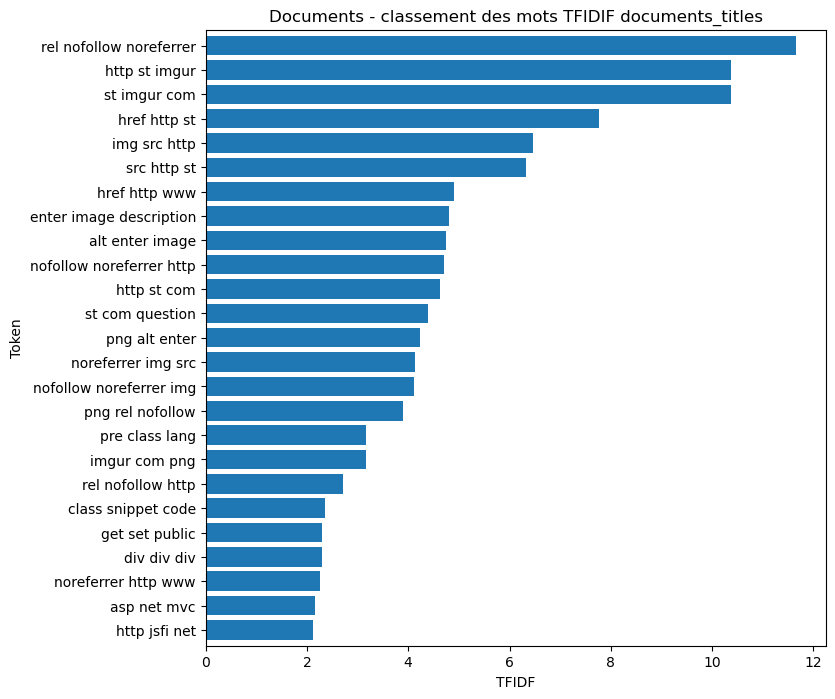

In [86]:
ax = sortedTFIDF_documents_titles.head(25).plot(kind='barh', width=0.80)
ax.invert_yaxis()
ax.set(xlabel='TFIDF', ylabel='Token', title='Documents - classement des mots TFIDIF documents_titles')

In [87]:
X=dfTFIDF_documents_titles.values

In [88]:
#%%time
from sklearn.manifold import TSNE

tsne = TSNE(random_state=1, n_jobs=2,n_iter=1000, n_components = 2)
tsne_results = tsne.fit_transform(X)
tsne_results.shape

/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(2000, 2)

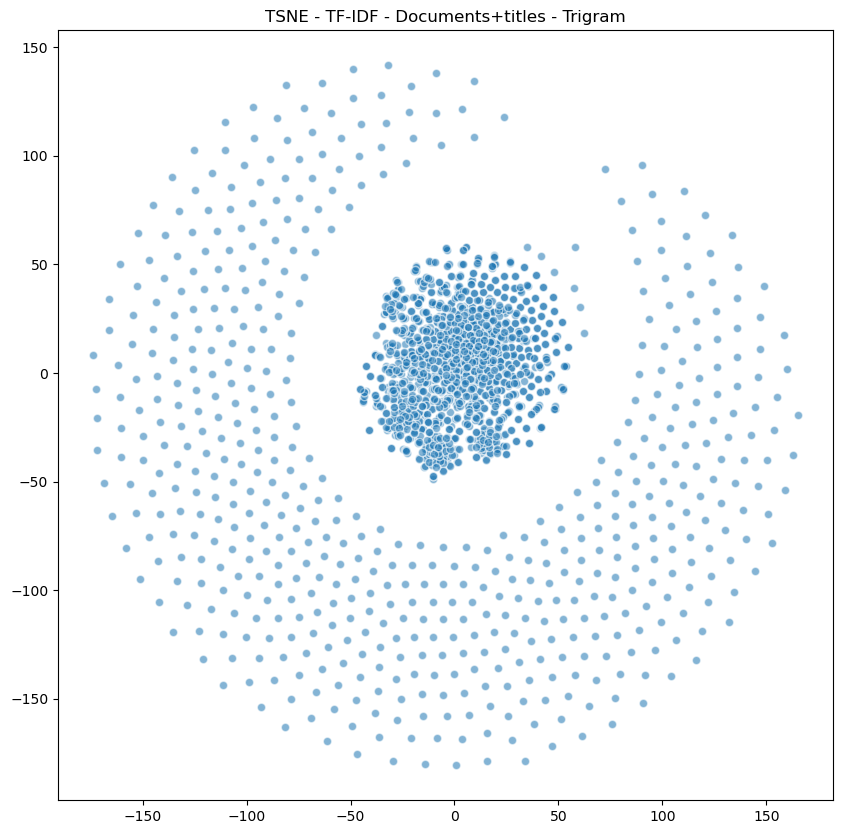

In [89]:
plt.figure(figsize = (10,10))


plt.scatter(tsne_results[:,0],tsne_results[:,1], edgecolor = "white", alpha=0.55)
plt.title('TSNE - TF-IDF - Documents+titles - Trigram')
plt.show()

In [90]:
commonTokens=list(set(dfTFIDF_titles.columns) & set(dfTFIDF_documents.columns))
dfTFIDFCommon=dfTFIDF_titles[0:10000][commonTokens]*0.8+dfTFIDF_documents[0:10000][commonTokens]*0.2
sortedTFIDFCommon=dfTFIDFCommon.sum(axis=0).sort_values(ascending=False)

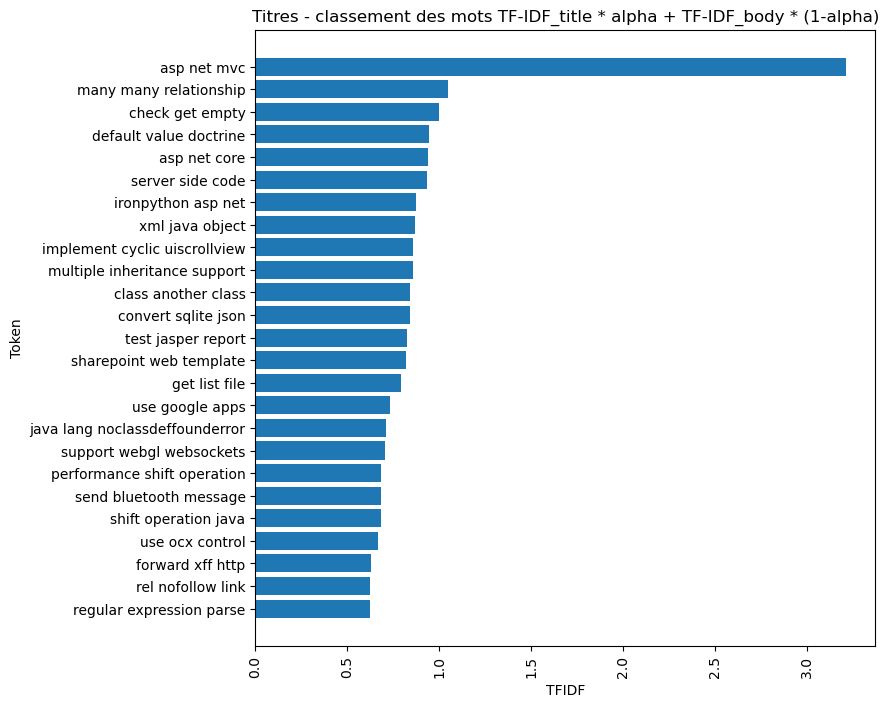

In [91]:
plt.figure(figsize=(8,8))

plt.barh(sortedTFIDFCommon.head(25).index,sortedTFIDFCommon.head(25).values)
plt.gca().invert_yaxis()

plt.xlabel("TFIDF")
plt.xticks(rotation='vertical')

plt.ylabel("Token")
plt.title("Titres - classement des mots TF-IDF_title * alpha + TF-IDF_body * (1-alpha)")
plt.show()

In [92]:
X=dfTFIDFCommon

In [93]:
#%%time
from sklearn.manifold import TSNE

tsne = TSNE(random_state=1, n_jobs=2,n_iter=1000, n_components = 2)
tsne_results = tsne.fit_transform(X)
tsne_results.shape

/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(2000, 2)

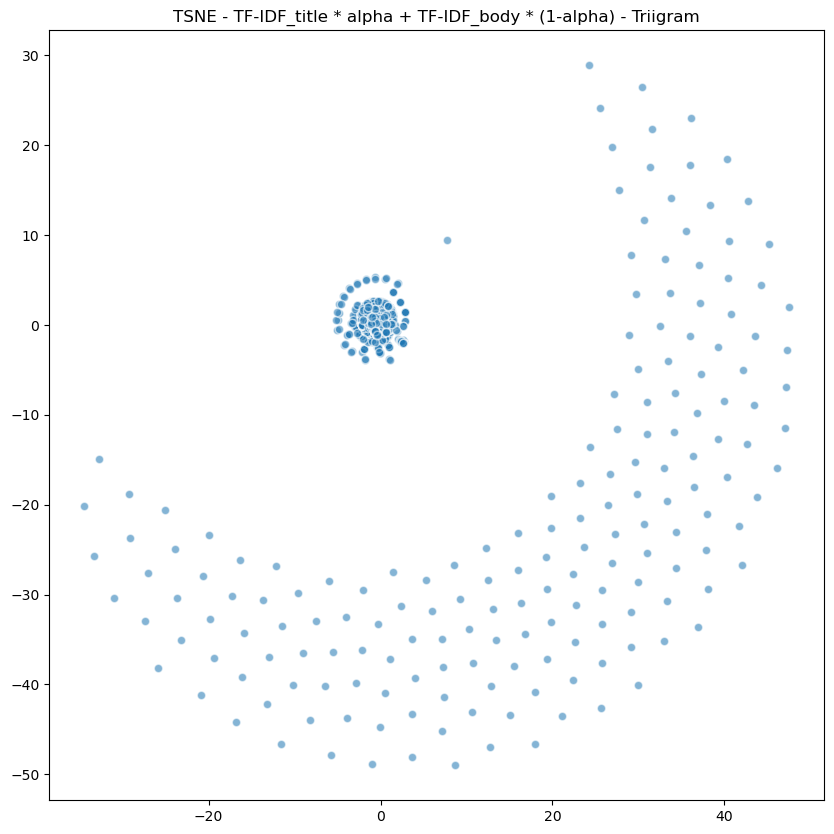

In [94]:
plt.figure(figsize = (10,10))


plt.scatter(tsne_results[:,0],tsne_results[:,1], edgecolor = "white", alpha=0.55)
plt.title('TSNE - TF-IDF_title * alpha + TF-IDF_body * (1-alpha) - Triigram')
plt.show()

# LDA

In [95]:
# Vectorize document using TF-IDF
tfidf = TfidfVectorizer(lowercase=True,
                        stop_words='english',
                        ngram_range = (1,1),
                        tokenizer = tokenize)

# Fit and Transform the documents
train_data = tfidf.fit_transform(documents)
train_data

NameError: name 'tokenize' is not defined

In [ ]:
# Define the number of topics or components
num_components=20

# Create LDA object
model=LatentDirichletAllocation(n_components=num_components)

# Fit and Transform SVD model on data
lda_matrix = model.fit_transform(train_data)

# Get Components 
lda_components=model.components_

# Print the topics with their terms
terms = tfidf.get_feature_names()

for index, component in enumerate(lda_components):
    zipped = zip(terms, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:7]
    top_terms_list=list(dict(top_terms_key).keys())
    print("Topic "+str(index)+": ",top_terms_list)